
# FASHION GAN- Simple GAN Implementation

## Connecting T4 GPU

In [1]:
import tensorflow as tf

In [2]:
gpus = tf.config.experimental.list_physical_devices("GPU")
for gpu in gpus:
  tf.config.experimental.set_memory_growth(gpu,True)

print(gpus)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [3]:
!nvidia-smi

Fri Apr  5 08:37:25 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   52C    P8              10W /  70W |      3MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [4]:
!pip install tensorflow-datasets matplotlib

In [5]:
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt

## Data Preparation

In [6]:
ds = tfds.load("fashion_mnist",split="train")
ds

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/60000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/fashion_mnist/3.0.1.incompleteNZ73QX/fashion_mnist-train.tfrecord*...:   0…

Generating test examples...:   0%|          | 0/10000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/fashion_mnist/3.0.1.incompleteNZ73QX/fashion_mnist-test.tfrecord*...:   0%…

Dataset fashion_mnist downloaded and prepared to /root/tensorflow_datasets/fashion_mnist/3.0.1. Subsequent calls will reuse this data.


<_PrefetchDataset element_spec={'image': TensorSpec(shape=(28, 28, 1), dtype=tf.uint8, name=None), 'label': TensorSpec(shape=(), dtype=tf.int64, name=None)}>

In [7]:
ds.as_numpy_iterator().next()

{'image': array([[[  0],
         [  0],
         [  0],
         [  0],
         [  0],
         [  0],
         [  0],
         [  0],
         [  0],
         [ 18],
         [ 77],
         [227],
         [227],
         [208],
         [210],
         [225],
         [216],
         [ 85],
         [ 32],
         [  0],
         [  0],
         [  0],
         [  0],
         [  0],
         [  0],
         [  0],
         [  0],
         [  0]],
 
        [[  0],
         [  0],
         [  0],
         [  0],
         [  0],
         [  0],
         [  0],
         [ 61],
         [100],
         [ 97],
         [ 80],
         [ 57],
         [117],
         [227],
         [238],
         [115],
         [ 49],
         [ 78],
         [106],
         [108],
         [ 71],
         [  0],
         [  0],
         [  0],
         [  0],
         [  0],
         [  0],
         [  0]],
 
        [[  0],
         [  0],
         [  0],
         [  0],
         [  0],
         

## Data Viz, Dataset Building

In [8]:
import numpy as np

In [9]:
dataiter = ds.as_numpy_iterator()

In [10]:
# Getting Data Out of Pipeline  :
dataiter.next()

{'image': array([[[  0],
         [  0],
         [  0],
         [  0],
         [  0],
         [  0],
         [  0],
         [  0],
         [  0],
         [ 18],
         [ 77],
         [227],
         [227],
         [208],
         [210],
         [225],
         [216],
         [ 85],
         [ 32],
         [  0],
         [  0],
         [  0],
         [  0],
         [  0],
         [  0],
         [  0],
         [  0],
         [  0]],
 
        [[  0],
         [  0],
         [  0],
         [  0],
         [  0],
         [  0],
         [  0],
         [ 61],
         [100],
         [ 97],
         [ 80],
         [ 57],
         [117],
         [227],
         [238],
         [115],
         [ 49],
         [ 78],
         [106],
         [108],
         [ 71],
         [  0],
         [  0],
         [  0],
         [  0],
         [  0],
         [  0],
         [  0]],
 
        [[  0],
         [  0],
         [  0],
         [  0],
         [  0],
         

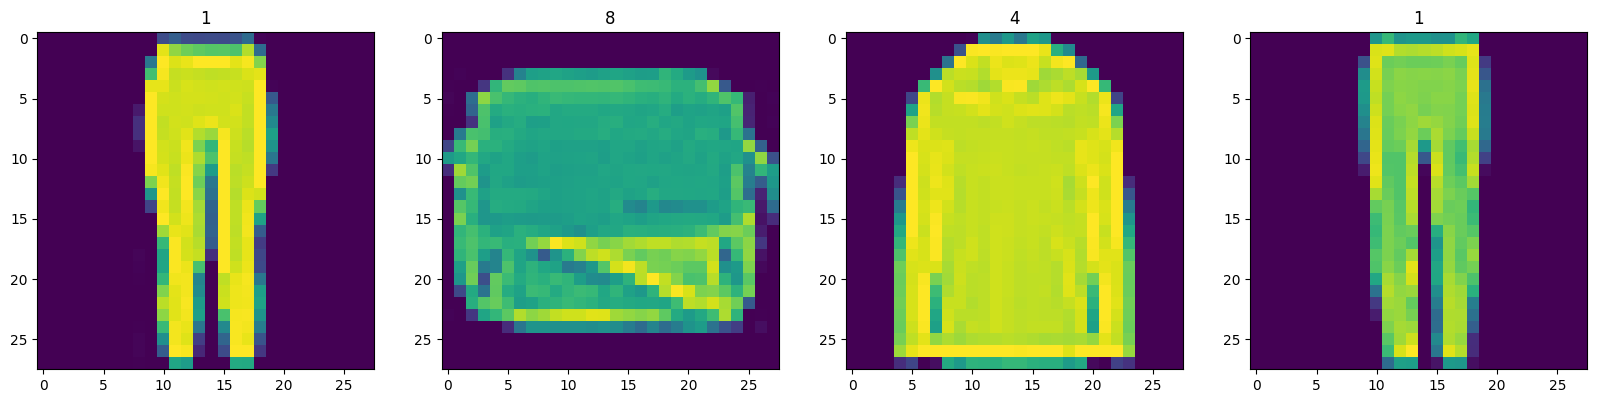

In [11]:
fig, ax = plt.subplots(ncols = 4, figsize = (20,20))

for i in range(4):
  batch = dataiter.next()
  ax[i].imshow(np.squeeze(batch['image'])) # Squeeze to reduce dimensions
  ax[i].title.set_text(batch['label'])

In [12]:
# Scaling Images :
def scale_imgs(data):
  image = data['image']
  return image/255

In [13]:
# Reloading Dataset
ds = tfds.load('fashion_mnist',split = "train")
ds = ds.map(scale_imgs) # Scale Images
ds = ds.cache() # Cache Dataset for that batch
ds = ds.shuffle(60000) # Shuffle
ds = ds.batch(128) # set Batches of 128 images per sample
ds = ds.prefetch(64) # reduce likelihood of bottlenecking

In [14]:
ds.as_numpy_iterator().next().shape

(128, 28, 28, 1)

## Building Neural Network

 Building the generator and discriminator for GAN

 Generator : Generate Images


 Discriminator : Spot the fakes

### Importing Modeling Components :

In [15]:
# Sequential API For Generator and Discriminator
from tensorflow.keras.models import Sequential
# Layer components for Building the Neural Network
from tensorflow.keras.layers import Conv2D, Dense, Flatten, Reshape, LeakyReLU, Dropout, UpSampling2D

### Building Generator

In [30]:
def build_generator():
  model = Sequential()

  # Takes in random values, reshape to 7*7*128
  model.add(Dense(7*7*128,input_dim = 128))
  model.add(LeakyReLU(0.2))
  model.add(Reshape((7,7,128)))

  # Upsampling block 1 :
  model.add(UpSampling2D()) # Doubles the previous dimensions
  model.add(Conv2D(128,5,padding = "same"))
  model.add(LeakyReLU(0.2))

  # Upsampling block 1 :
  model.add(UpSampling2D()) # Doubles the previous dimensions
  model.add(Conv2D(128,5,padding = "same"))
  model.add(LeakyReLU(0.2))

  # Down Sampling Block 1 :
  model.add(Conv2D(128,4,padding = "same"))
  model.add(LeakyReLU(0.2))

  # Down Sampling Block 2 :
  model.add(Conv2D(128,4,padding = "same"))
  model.add(LeakyReLU(0.2))

  # Conv Layer to get one Channel :
  model.add(Conv2D(1,4,padding = "same",activation = "sigmoid"))

  return model

In [31]:
test = build_generator()
test.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 6272)              809088    
                                                                 
 leaky_re_lu_11 (LeakyReLU)  (None, 6272)              0         
                                                                 
 reshape_4 (Reshape)         (None, 7, 7, 128)         0         
                                                                 
 up_sampling2d_3 (UpSamplin  (None, 14, 14, 128)       0         
 g2D)                                                            
                                                                 
 conv2d_9 (Conv2D)           (None, 14, 14, 128)       409728    
                                                                 
 leaky_re_lu_12 (LeakyReLU)  (None, 14, 14, 128)       0         
                                                      

In [32]:
generator = build_generator()
generator.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_5 (Dense)             (None, 6272)              809088    
                                                                 
 leaky_re_lu_16 (LeakyReLU)  (None, 6272)              0         
                                                                 
 reshape_5 (Reshape)         (None, 7, 7, 128)         0         
                                                                 
 up_sampling2d_5 (UpSamplin  (None, 14, 14, 128)       0         
 g2D)                                                            
                                                                 
 conv2d_14 (Conv2D)          (None, 14, 14, 128)       409728    
                                                                 
 leaky_re_lu_17 (LeakyReLU)  (None, 14, 14, 128)       0         
                                                      

In [33]:
img = generator.predict(np.random.randn(4,128,1))
img
print(len(img))
print(img.shape)

1/1 [==============================] - 0s 364ms/step
4
(4, 28, 28, 1)


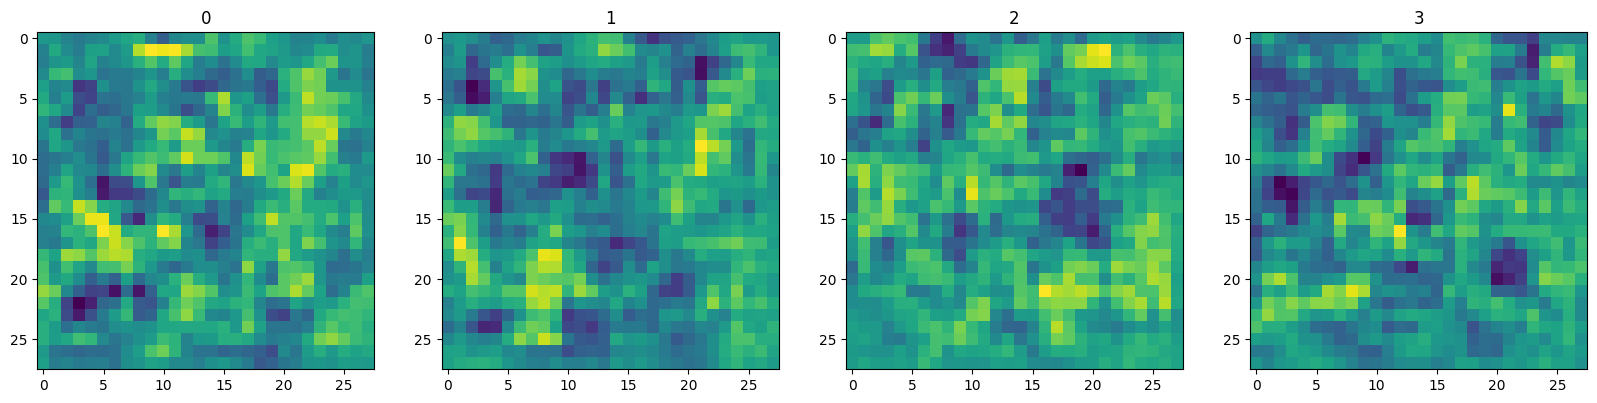

In [34]:
fig, ax = plt.subplots(ncols = 4, figsize = (20,20))

for idx,img in enumerate(img):
  ax[idx].imshow(np.squeeze(img)) # Squeeze to reduce dimensions
  ax[idx].title.set_text(idx)

### Building Discriminator

In [59]:
def build_discriminator():
  model = Sequential()

  # First Conv block
  model.add(Conv2D(32,5,input_shape = (28,28,1)))
  model.add(LeakyReLU(0.2))
  model.add(Dropout(0.4))

  # Second Conv Block
  model.add(Conv2D(64,5))
  model.add(LeakyReLU(0.2))
  model.add(Dropout(0.4))

  # Third Conv Block
  model.add(Conv2D(128,5))
  model.add(LeakyReLU(0.2))
  model.add(Dropout(0.4))

  # Fourth Conv Block
  model.add(Conv2D(256,5))
  model.add(LeakyReLU(0.2))
  model.add(Dropout(0.4))

  # Flatten -> Dense Layer
  model.add(Flatten())
  model.add(Dropout(0.4))
  model.add(Dense(1,activation = "sigmoid"))

  return model

In [60]:
discriminator = build_discriminator()

In [61]:
discriminator.summary()

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_35 (Conv2D)          (None, 24, 24, 32)        832       
                                                                 
 leaky_re_lu_37 (LeakyReLU)  (None, 24, 24, 32)        0         
                                                                 
 dropout_18 (Dropout)        (None, 24, 24, 32)        0         
                                                                 
 conv2d_36 (Conv2D)          (None, 20, 20, 64)        51264     
                                                                 
 leaky_re_lu_38 (LeakyReLU)  (None, 20, 20, 64)        0         
                                                                 
 dropout_19 (Dropout)        (None, 20, 20, 64)        0         
                                                                 
 conv2d_37 (Conv2D)          (None, 16, 16, 128)     

In [73]:
img1 = generator.predict(np.random.randn(4,128,1))
img2 = img1[0]
img2.shape

1/1 [==============================] - 0s 23ms/step


(28, 28, 1)

In [74]:
discriminator.predict(np.expand_dims(img2,0))

1/1 [==============================] - 0s 19ms/step


array([[0.4998907]], dtype=float32)

In [76]:
discriminator.predict(np.expand_dims(img1[2],0))

1/1 [==============================] - 0s 68ms/step


array([[0.50006914]], dtype=float32)

## Constructing Training Loop

### Losses and Optimizers

In [77]:
from tensorflow.keras.optimizers import Adam # Optimizer for both
from tensorflow.keras.losses import BinaryCrossentropy # Loss for both generator and discriminator

In [78]:
g_opt = Adam(learning_rate=0.0001) # Generator
d_opt = Adam(learning_rate=0.00001) # Discriminator
g_loss = BinaryCrossentropy()
d_loss = BinaryCrossentropy()

### Building Subclassed Model

In [79]:
from tensorflow.keras.models import Model # Importing Base Model class to subclass for training step

In [122]:
class FashionGAN(Model):
    def __init__(self, generator, discriminator, *args, **kwargs):
        # Pass through args and kwargs to base class
        super().__init__(*args, **kwargs)

        # Create attributes for gen and disc
        self.generator = generator
        self.discriminator = discriminator

    def compile(self, g_opt, d_opt, g_loss, d_loss, *args, **kwargs):
        # Compile with base class
        super().compile(*args, **kwargs)

        # Create attributes for losses and optimizers
        self.g_opt = g_opt
        self.d_opt = d_opt
        self.g_loss = g_loss
        self.d_loss = d_loss

    def train_step(self, batch):
        # Get the data
        real_images = batch
        fake_images = self.generator(tf.random.normal((128, 128, 1)), training=False)

        # Train the discriminator
        with tf.GradientTape() as d_tape:
            # Pass the real and fake images to the discriminator model
            yhat_real = self.discriminator(real_images, training=True)
            yhat_fake = self.discriminator(fake_images, training=True)
            yhat_realfake = tf.concat([yhat_real, yhat_fake], axis=0)

            # Create labels for real and fakes images
            y_realfake = tf.concat([tf.zeros_like(yhat_real), tf.ones_like(yhat_fake)], axis=0)

            # Add some noise to the TRUE outputs
            noise_real = 0.15*tf.random.uniform(tf.shape(yhat_real))
            noise_fake = -0.15*tf.random.uniform(tf.shape(yhat_fake))
            y_realfake += tf.concat([noise_real, noise_fake], axis=0)

            # Calculate loss - BINARYCROSS
            total_d_loss = self.d_loss(y_realfake, yhat_realfake)

        # Apply backpropagation - nn learn
        dgrad = d_tape.gradient(total_d_loss, self.discriminator.trainable_variables)
        self.d_opt.apply_gradients(zip(dgrad, self.discriminator.trainable_variables))

        # Train the generator
        with tf.GradientTape() as g_tape:
            # Generate some new images
            gen_images = self.generator(tf.random.normal((128,128,1)), training=True)

            # Create the predicted labels
            predicted_labels = self.discriminator(gen_images, training=False)

            # Calculate loss - trick to training to fake out the discriminator
            total_g_loss = self.g_loss(tf.zeros_like(predicted_labels), predicted_labels)

        # Apply backprop
        ggrad = g_tape.gradient(total_g_loss, self.generator.trainable_variables)
        self.g_opt.apply_gradients(zip(ggrad, self.generator.trainable_variables))

        return {"d_loss":total_d_loss, "g_loss":total_g_loss}

In [123]:
fashiongan = FashionGAN(generator,discriminator)

In [124]:
fashiongan.compile(
    g_opt=tf.keras.optimizers.Adam(),
    d_opt=tf.keras.optimizers.Adam(),
    g_loss=tf.keras.losses.BinaryCrossentropy(),
    d_loss=tf.keras.losses.BinaryCrossentropy(),
)


### Building Callback

In [125]:
import os
from tensorflow.keras.preprocessing.image import array_to_img
from tensorflow.keras.callbacks import Callback

In [128]:
class ModelMonitor(Callback):
    def __init__(self, num_img=3, latent_dim=128):
        self.num_img = num_img
        self.latent_dim = latent_dim

    def on_epoch_end(self, epoch, logs=None):
        random_latent_vectors = tf.random.uniform((self.num_img, self.latent_dim,1))
        generated_images = self.model.generator(random_latent_vectors)
        generated_images *= 255
        generated_images.numpy()
        for i in range(self.num_img):
            img = array_to_img(generated_images[i])
            img.save(os.path.join('/images', f'generated_img_{epoch}_{i}.png'))

### Train

In [ ]:
hist = fashiongan.fit(ds, epochs=20, callbacks=[ModelMonitor()])

Epoch 1/20
  6/469 [..............................] - ETA: 1:10 - d_loss: 0.2626 - g_loss: 2.6311

469/469 [==============================] - 74s 158ms/step - d_loss: 0.2674 - g_loss: 2.6184
Epoch 2/20
469/469 [==============================] - 76s 162ms/step - d_loss: 0.2677 - g_loss: 2.6046
Epoch 3/20
469/469 [==============================] - 76s 162ms/step - d_loss: 0.2677 - g_loss: 2.5991
Epoch 4/20
469/469 [==============================] - 76s 162ms/step - d_loss: 0.2669 - g_loss: 2.5993
Epoch 5/20
469/469 [==============================] - 76s 162ms/step - d_loss: 0.2668 - g_loss: 2.5979
Epoch 6/20
469/469 [==============================] - 76s 162ms/step - d_loss: 0.2673 - g_loss: 2.5977
Epoch 7/20
469/469 [==============================] - 76s 162ms/step - d_loss: 0.2666 - g_loss: 2.6016
Epoch 8/20
469/469 [==============================] - 76s 162ms/step - d_loss: 0.2675 - g_loss: 2.6001
Epoch 9/20
469/469 [==============================] - 76s 163ms/step - d_loss: 0.2672 - g_loss: 2.5987
Epoch 10/20
469/469 [==============================] - 76s 162ms/step - d_loss: 0.26

## Model Performance Evaluation

In [ ]:
plt.suptitle("Loss")
plt.plot(hist.history['d_loss'],label = "d_loss")
plt.plot(hist.history['g_loss'],label = "g_loss")
plt.legend()
plt.show()